# Импорт библиотек

In [1]:
import shap
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureDrift
from imblearn.over_sampling import SMOTENC, RandomOverSampler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    f1_score,
    precision_recall_curve,
    roc_curve, 
    auc
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from catboost import (
    CatBoostClassifier,
    Pool, 
    cv, 
    EShapCalcType, 
    EFeaturesSelectionAlgorithm
)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

### Функция для обучения базовой модели

In [2]:
def fit_catboost(features_train, 
                 features_val, 
                 target_train, 
                 target_val, 
                 cat_features, 
                 n_iter=None,
                 lr=None,
                 loss='MultiClass',
                 plot=True,
                 train_weight=None,
                 val_weight=None):
    
    pool_train = Pool(
        features_train,
        target_train,
        weight = train_weight,
        cat_features = cat_features
    )

    pool_val = Pool(
        features_val,
        target_val,
        weight = val_weight,
        cat_features = cat_features
    )

    model = CatBoostClassifier(
        iterations = n_iter,
        learning_rate = lr,
        loss_function = loss,
        random_seed = 42
    )

    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=100,
        early_stopping_rounds = 15,
        plot=plot
    )

    return model

# Чтение данных

In [3]:
train_df = pd.read_csv('data/train.csv', sep=";", decimal=",", encoding="windows-1251")
test_df = pd.read_csv('data/test.csv', sep=";", decimal=",", encoding="windows-1251")

features_description = (
    pd.read_excel('data/description.xlsx', index_col='field')
    .to_dict()['description']
)

train_df.shape, test_df.shape

((205962, 235), (37183, 233))

# Предварительный анализ EDA

In [4]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)

### Поправляем типы данных для фичей

In [5]:
print('Количество униклаьных значений по фиче:')
for f in train_df[features].select_dtypes('object').columns:
    print(f"{f}: {train_df[f].value_counts().count()}")

Количество униклаьных значений по фиче:
addrref: 59
bki_total_ip_max_limit: 2763
hdb_bki_active_cc_cnt: 60
hdb_bki_active_ip_max_outstand: 43267
hdb_bki_active_micro_max_outstand: 5458
hdb_bki_active_pil_max_overdue: 24365
hdb_bki_other_active_auto_month_payments_sum: 3533
hdb_bki_total_cc_max_limit: 9991
hdb_bki_total_ip_cnt: 15
hdb_bki_total_max_limit: 52263
hdb_bki_total_max_overdue_sum: 56162
hdb_bki_total_pil_max_limit: 54202
main_last_position_ccode: 9207
main_pre_last_position_ccode: 5192
oldest_campaignsegment_ccode_for_nss: 56
oldest_campaignsegment_ccode_for_pil: 13
part_last_position_ccode: 1236
part_pre_last_position_ccode: 1325
segment: 3
brand: 422
model: 2397


В соответствии с описанием фичей было выяснено, что для всех фичей, которые начинаются с 'hdb_bki' требуется выставить тип данных float

In [6]:
newtype_feats = [
    'bki_total_ip_max_limit',
    'hdb_bki_active_cc_cnt',
    'hdb_bki_active_ip_max_outstand',
    'hdb_bki_active_micro_max_outstand',
    'hdb_bki_active_pil_max_overdue',
    'hdb_bki_other_active_auto_month_payments_sum',
    'hdb_bki_total_cc_max_limit',
    'hdb_bki_total_ip_cnt',
    'hdb_bki_total_max_limit',
    'hdb_bki_total_max_overdue_sum',
    'hdb_bki_total_pil_max_limit'
]

test_df[newtype_feats] = test_df[newtype_feats].astype('float64')
test_df['feature_date'] = test_df['feature_date'].astype('datetime64[ns]')

train_df[newtype_feats] = train_df[newtype_feats].astype('float64')
train_df['feature_date'] = train_df['feature_date'].astype('datetime64[ns]')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205962 entries, 0 to 205961
Columns: 235 entries, client_id to productionyear
dtypes: datetime64[ns](1), float64(223), int64(1), object(10)
memory usage: 369.3+ MB


In [7]:
cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(231, 10, 221)

### Анализ категорильных фичей

In [8]:
# сколько всего записей, где известна должность, но не известна зп?
train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(4184, 235)

In [9]:
# df, содержащий медианные зарплаты для должностей по всем данным
median_worksalary = (
    pd.concat([train_df[features], test_df[features]], axis=0)
    .dropna(subset = 'worksalary_rur_amt')
    .groupby('part_last_position_ccode', as_index=False)
    ['worksalary_rur_amt'].median()
    .rename(columns={'worksalary_rur_amt': 'median_worksalary_rur_amt'})
)
median_worksalary.head()

,part_last_position_ccode,median_worksalary_rur_amt
0,АВТОМЕХАНИК,158892.5
1,АДМИНИСТРАТОР,180000.0
2,АНАЛИТИК,100000.0
3,Администратор,60000.0
4,Администратор магазина,70000.0


In [10]:
test_df = test_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
test_df['worksalary_rur_amt'] = test_df['worksalary_rur_amt'].fillna(test_df['median_worksalary_rur_amt'])
test_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df = train_df.merge(median_worksalary, on='part_last_position_ccode', how='left')
train_df['worksalary_rur_amt'] = train_df['worksalary_rur_amt'].fillna(train_df['median_worksalary_rur_amt'])
train_df.drop('median_worksalary_rur_amt', axis=1, inplace=True)

train_df.loc[
    (train_df['worksalary_rur_amt'].isna())
    & (~train_df['part_last_position_ccode'].isna())
].shape

(1029, 235)

In [11]:
# заполняем пропуски в категориальных
train_df[cat_features] = train_df[cat_features].fillna('miss_value')
test_df[cat_features] = test_df[cat_features].fillna('miss_value')

# Инженерия фич

In [12]:
train_df['feature_date_year'] = train_df['feature_date'].dt.year
train_df['feature_date_month'] = train_df['feature_date'].dt.month
train_df['feature_date_day'] = train_df['feature_date'].dt.day

test_df['feature_date_year'] = test_df['feature_date'].dt.year
test_df['feature_date_month'] = test_df['feature_date'].dt.month
test_df['feature_date_day'] = test_df['feature_date'].dt.day

In [13]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)

cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(234, 10, 224)

# Подбор оптимального количества бинов таргета

<Axes: xlabel='target', ylabel='Density'>

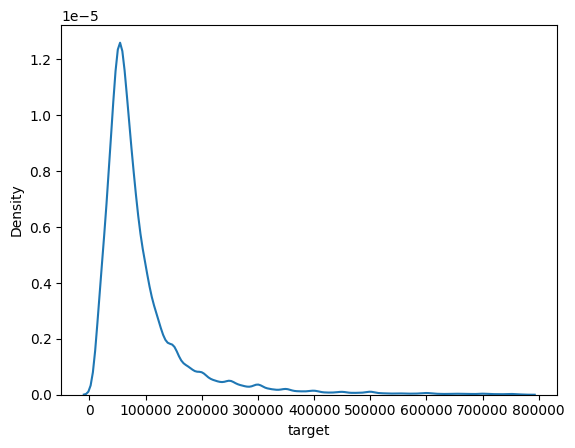

In [14]:
sns.kdeplot(train_df['target'])

In [29]:
def find_opt_bins(df, features, cat_features, max_bin):
    
    for n_bins in range(2, max_bin):

        df['target_bins'] = pd.qcut(df['target'], q=n_bins)
        df['target_bins'] = df['target_bins'].astype('string')

        le = LabelEncoder()
        df['target_bins'] = le.fit_transform(df['target_bins'])

        features_train, features_val, target_train, target_val = train_test_split(
            df[features],
            df['target_bins'],
            test_size=0.3,
            random_state=42
        )

        model = fit_catboost(features_train, features_val, target_train, target_val, cat_features)

        print(
            classification_report(
                target_val, 
                model.predict(features_val),
                target_names = unique_labels(le.inverse_transform(target_val))
            ) 
        )

find_opt_bins(train_df, features, cat_features, 5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.119263
0:	learn: 0.6587347	test: 0.6587849	best: 0.6587849 (0)	total: 267ms	remaining: 4m 27s
100:	learn: 0.4158147	test: 0.4195039	best: 0.4195039 (100)	total: 23.8s	remaining: 3m 32s
200:	learn: 0.3995015	test: 0.4073655	best: 0.4073655 (200)	total: 47.1s	remaining: 3m 7s
300:	learn: 0.3914188	test: 0.4032179	best: 0.4032162 (299)	total: 1m 9s	remaining: 2m 42s
400:	learn: 0.3860247	test: 0.4010925	best: 0.4010925 (400)	total: 1m 33s	remaining: 2m 20s
500:	learn: 0.3812645	test: 0.3996861	best: 0.3996861 (500)	total: 1m 55s	remaining: 1m 55s
600:	learn: 0.3771509	test: 0.3985290	best: 0.3985290 (600)	total: 2m 17s	remaining: 1m 31s
700:	learn: 0.3733297	test: 0.3977513	best: 0.3977513 (700)	total: 2m 40s	remaining: 1m 8s
800:	learn: 0.3699681	test: 0.3970545	best: 0.3970263 (796)	total: 3m 2s	remaining: 45.4s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 0.3970262769
bestIteration = 796

Shrink model to first 797 iterations.


d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



                        precision    recall  f1-score   support

(13000.249, 67659.215]       0.80      0.84      0.82     30810
(67659.215, 769845.36]       0.83      0.79      0.81     30979

              accuracy                           0.81     61789
             macro avg       0.81      0.81      0.81     61789
          weighted avg       0.81      0.81      0.81     61789



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.119263
0:	learn: 1.0470104	test: 1.0465506	best: 1.0465506 (0)	total: 387ms	remaining: 6m 27s
100:	learn: 0.6826049	test: 0.6884942	best: 0.6884942 (100)	total: 36.7s	remaining: 5m 26s
200:	learn: 0.6566799	test: 0.6695144	best: 0.6695144 (200)	total: 1m 15s	remaining: 4m 59s
300:	learn: 0.6434835	test: 0.6623341	best: 0.6623341 (300)	total: 1m 52s	remaining: 4m 20s
400:	learn: 0.6353889	test: 0.6593012	best: 0.6592942 (399)	total: 2m 27s	remaining: 3m 40s
500:	learn: 0.6283431	test: 0.6570250	best: 0.6570250 (500)	total: 3m 1s	remaining: 3m
600:	learn: 0.6215061	test: 0.6553125	best: 0.6553125 (600)	total: 3m 37s	remaining: 2m 24s
700:	learn: 0.6156795	test: 0.6538021	best: 0.6538021 (700)	total: 4m 11s	remaining: 1m 47s
800:	learn: 0.6099302	test: 0.6529696	best: 0.6529696 (800)	total: 4m 46s	remaining: 1m 11s
900:	learn: 0.6047250	test: 0.6521884	best: 0.6521776 (899)	total: 5m 22s	remaining: 35.5s
999:	learn: 0.5996348	test: 0.6516737	best: 0.6516685 (993)	to

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



                        precision    recall  f1-score   support

(13000.249, 53957.852]       0.70      0.78      0.74     20499
(53957.852, 88049.296]       0.66      0.60      0.62     20581
(88049.296, 769845.36]       0.78      0.76      0.77     20709

              accuracy                           0.71     61789
             macro avg       0.71      0.71      0.71     61789
          weighted avg       0.71      0.71      0.71     61789



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.119263
0:	learn: 1.3235167	test: 1.3236369	best: 1.3236369 (0)	total: 733ms	remaining: 12m 12s
100:	learn: 0.9001636	test: 0.9081930	best: 0.9081930 (100)	total: 54.8s	remaining: 8m 7s
200:	learn: 0.8620652	test: 0.8785371	best: 0.8785371 (200)	total: 1m 49s	remaining: 7m 15s
300:	learn: 0.8463527	test: 0.8697124	best: 0.8697124 (300)	total: 2m 46s	remaining: 6m 26s
400:	learn: 0.8334885	test: 0.8635952	best: 0.8635952 (400)	total: 3m 39s	remaining: 5m 27s
500:	learn: 0.8244245	test: 0.8604058	best: 0.8604058 (500)	total: 4m 32s	remaining: 4m 31s
600:	learn: 0.8168361	test: 0.8584325	best: 0.8584325 (600)	total: 5m 25s	remaining: 3m 35s
700:	learn: 0.8104752	test: 0.8568061	best: 0.8568020 (699)	total: 6m 15s	remaining: 2m 40s
800:	learn: 0.8031381	test: 0.8554561	best: 0.8554561 (800)	total: 7m 8s	remaining: 1m 46s
900:	learn: 0.7959477	test: 0.8542246	best: 0.8542246 (900)	total: 8m 2s	remaining: 53s
999:	learn: 0.7894121	test: 0.8534796	best: 0.8534706 (991)	t

d:\ml\income-prediction-alfa-campus\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



#### Вывод:
Приемлимый скор получается при разбиении таргета на 3 класса. В файле 01_income_baseline было выяснено, что оптимальные границы бинов для регрессоров - квантили 0.7 и 0.9

# Какие границы бинов обеспечат максимальное качество классификатора

Подбор для q0=0.1------------------------------------------

Начало фолда.

0:	learn: 1.0406855	test: 1.0407711	best: 1.0407711 (0)	total: 251ms	remaining: 12.3s
49:	learn: 0.4777800	test: 0.4788972	best: 0.4788972 (49)	total: 12.6s	remaining: 0us

bestTest = 0.4788972494
bestIteration = 49

Начало фолда.

0:	learn: 1.0412984	test: 1.0413920	best: 1.0413920 (0)	total: 267ms	remaining: 13.1s
49:	learn: 0.4775920	test: 0.4798985	best: 0.4798985 (49)	total: 11.6s	remaining: 0us

bestTest = 0.4798984553
bestIteration = 49

Начало фолда.

0:	learn: 1.0414217	test: 1.0413452	best: 1.0413452 (0)	total: 237ms	remaining: 11.6s
49:	learn: 0.4784044	test: 0.4782991	best: 0.4782991 (49)	total: 10.9s	remaining: 0us

bestTest = 0.4782990741
bestIteration = 49

Начало фолда.

0:	learn: 1.0537540	test: 1.0537905	best: 1.0537905 (0)	total: 226ms	remaining: 11.1s
49:	learn: 0.5834713	test: 0.5849275	best: 0.5849275 (49)	total: 10.9s	remaining: 0us

bestTest = 0.5849275307
bestIteration = 49

Начало фолд

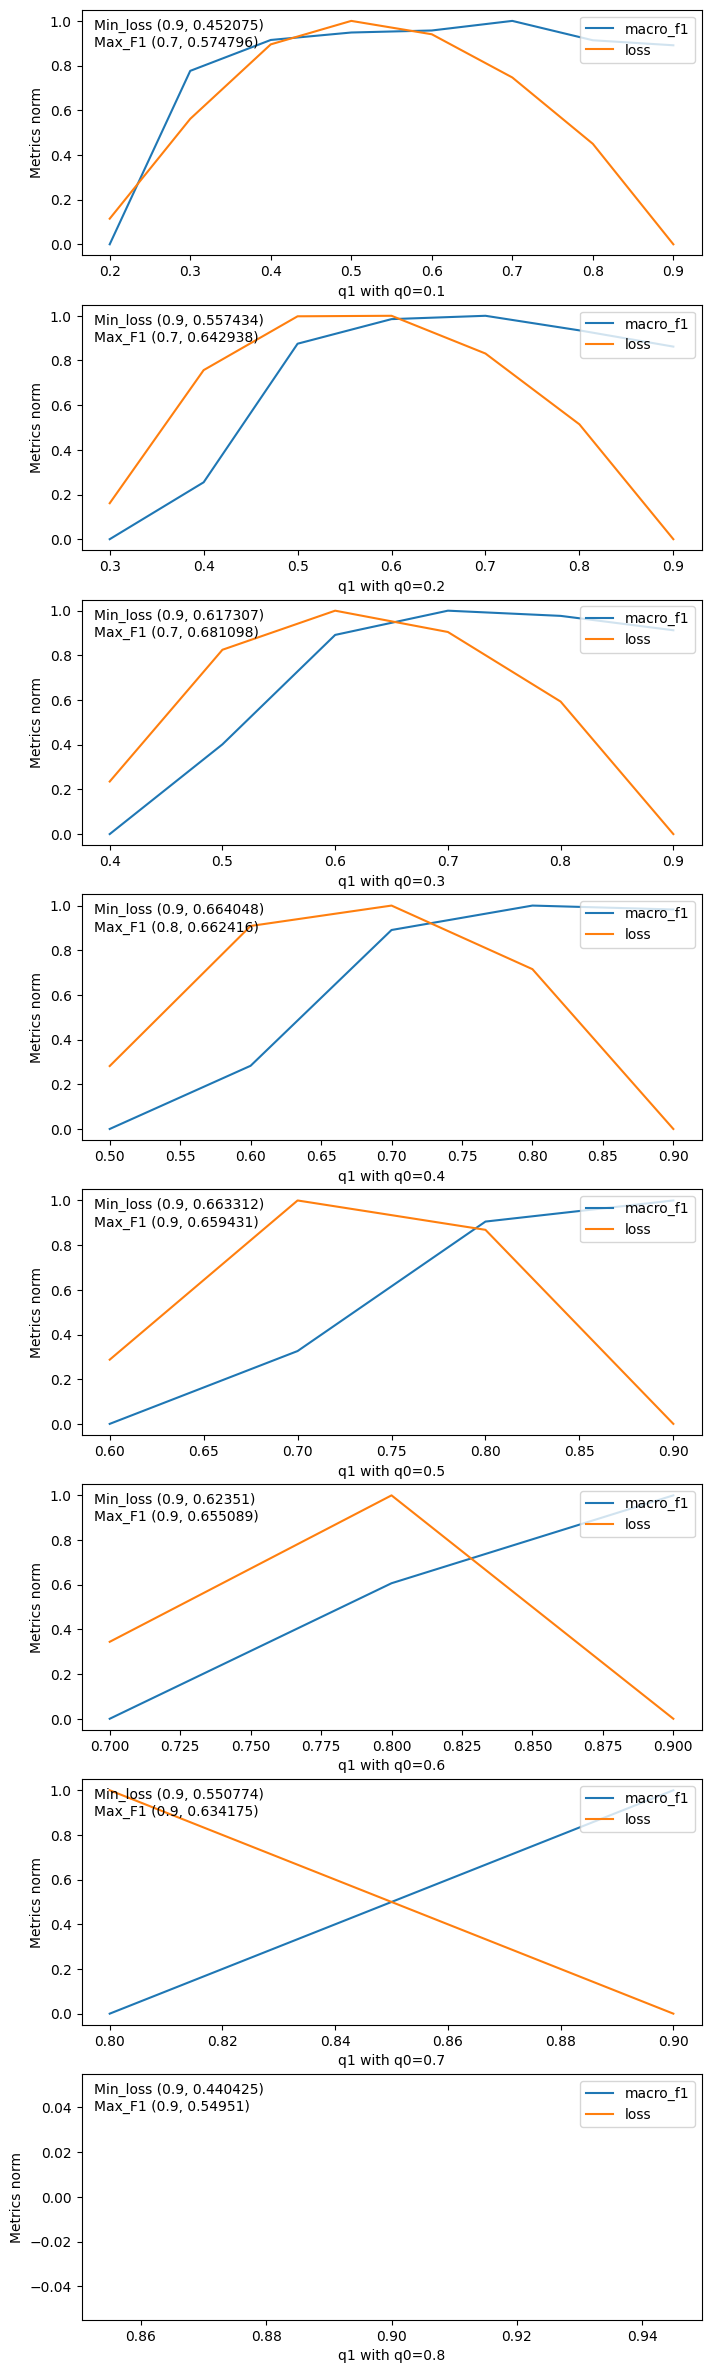

In [99]:
fig, axes = plt.subplots(8, 1, figsize=(8, 30))
quantiles = np.round(np.arange(0.1, 1, 0.1), 2)

for q0 in quantiles:

    print(f"Подбор для q0={1}{'-'*100}\n")

    ax = axes[int(q0*10)%9-1]
    f1_list = []
    loss_list = []

    if not np.where(quantiles > q0)[0].size:
        break

    q1s = quantiles[np.where(quantiles > q0)[0][0]:]

    for q1 in q1s:

        train_df['target_bins'] = None
        train_df.loc[train_df['target'] <= train_df['target'].quantile(q0), 'target_bins'] = 0
        train_df.loc[
            (train_df['target'] > train_df['target'].quantile(q0))
            & (train_df['target'] <= train_df['target'].quantile(q1)), 
            'target_bins'
        ] = 1
        train_df.loc[train_df['target'] > train_df['target'].quantile(q1), 'target_bins'] = 2
        train_df['target_bins'] = train_df['target_bins'].astype(int)

        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        f1_list_q1 = []
        loss_list_q1 = []

        for train_index, val_index in kf.split(train_df, train_df['target_bins']):
            print(f'Начало фолда.\n')

            cross_f_train, cross_f_val = train_df[features].loc[train_index], train_df[features].loc[val_index]
            cross_t_train, cross_t_val = train_df['target_bins'].loc[train_index], train_df['target_bins'].loc[val_index]

            model = fit_catboost(cross_f_train, cross_f_val, cross_t_train, cross_t_val, cat_features, 50, 0.05, plot=False)
            f1_list_q1.append(f1_score(cross_t_val, model.predict(cross_f_val)[:, 0], average='macro'))
            loss_list_q1.append(model.get_best_score()['validation']['MultiClass'])
        
        f1_list.append(sum(f1_list_q1)/3)
        loss_list.append(sum(loss_list_q1)/3)
    

    mms = MinMaxScaler()
    norm_f1 = mms.fit_transform(np.array(f1_list).reshape(-1, 1))
    norm_loss = mms.fit_transform(np.array(loss_list).reshape(-1, 1))

    df = pd.DataFrame(
        {
            'q1': np.concatenate((q1s, q1s)), 
            'metric_norm': np.concatenate((norm_f1, norm_loss)).reshape(-1), 
            'metric': f1_list + loss_list,
            'metric_name': ['macro_f1'] * len(q1s) + ['loss'] * len(q1s)
        }
    )

    min_m_indices = df.groupby('metric_name')['metric'].idxmin()
    max_m_indices = df.groupby('metric_name')['metric'].idxmax()

    sns.lineplot(data=df, x='q1', y='metric_norm', hue='metric_name', ax=ax)

    plt.text(
        0.02, 0.85, 
        f"Max_F1 ({df.loc[max_m_indices.macro_f1, 'q1']}, {round(df.loc[max_m_indices.macro_f1, 'metric'], 6)})", 
        fontsize=10, transform=ax.transAxes
    )
    plt.text(
        0.02, 0.92, 
        f"Min_loss ({df.loc[min_m_indices.loss, 'q1']}, {round(df.loc[min_m_indices.loss, 'metric'], 6)})", 
        fontsize=10, transform=ax.transAxes
    )
    ax.set(xlabel=f'q1 with q0={q0}', ylabel='Metrics norm')
    ax.legend(loc='upper right')

# Обучение модели 3 класса

In [15]:
train_df['target_bins'] = None
train_df.loc[train_df['target'] <= train_df['target'].quantile(0.333), 'target_bins'] = 'bin_0'
train_df.loc[
    (train_df['target'] > train_df['target'].quantile(0.333))
    & (train_df['target'] <= train_df['target'].quantile(0.666)), 
    'target_bins'
] = 'bin_1'
train_df.loc[train_df['target'] > train_df['target'].quantile(0.666), 'target_bins'] = 'bin_2'

In [16]:
le = LabelEncoder()
train_df['target_bins'] = le.fit_transform(train_df['target_bins'])

features_train, features_val, target_train, target_val = train_test_split(
    train_df[features],
    train_df['target_bins'], 
    test_size=0.3,
    random_state=42
)

## Дает ли профит андэрсемплинг?

In [17]:
reduced_majority_samples = target_train[target_train == 0].sample(frac=0.5, random_state=42)
target_train_resampled = pd.concat([reduced_majority_samples, target_train[target_train != 0]])
features_train_resampled = features_train.loc[target_train_resampled.index]

model = fit_catboost(features_train_resampled, features_val, target_train_resampled, target_val, cat_features, 500, 0.05)

print(
    classification_report(
        target_val, 
        model.predict(features_val),
        target_names = unique_labels(le.inverse_transform(target_val))
    ) 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0738832	test: 1.0771720	best: 1.0771720 (0)	total: 568ms	remaining: 4m 43s
100:	learn: 0.7065114	test: 0.7584631	best: 0.7584631 (100)	total: 34s	remaining: 2m 14s
200:	learn: 0.6746035	test: 0.7278576	best: 0.7278576 (200)	total: 1m 9s	remaining: 1m 43s
300:	learn: 0.6559088	test: 0.7111456	best: 0.7111456 (300)	total: 1m 42s	remaining: 1m 7s
400:	learn: 0.6449800	test: 0.7028066	best: 0.7028066 (400)	total: 2m 14s	remaining: 33.1s
499:	learn: 0.6377333	test: 0.6982595	best: 0.6982595 (499)	total: 2m 43s	remaining: 0us

bestTest = 0.6982594673
bestIteration = 499

              precision    recall  f1-score   support

       bin_0       0.83      0.51      0.63     20478
       bin_1       0.55      0.73      0.63     20557
       bin_2       0.75      0.78      0.76     20754

    accuracy                           0.67     61789
   macro avg       0.71      0.67      0.67     61789
weighted avg       0.71      0.67      0.67     61789



## Дает ли профит оверсэмплинг?

In [18]:
oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
features_train_resampled, target_train_resampled = oversample.fit_resample(features_train, target_train)

model = fit_catboost(features_train_resampled, features_val, target_train_resampled, target_val, cat_features, 500, 0.05)

print(
    classification_report(
        target_val, 
        model.predict(features_val),
        target_names = unique_labels(le.inverse_transform(target_val))
    ) 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0760231	test: 1.0759417	best: 1.0759417 (0)	total: 383ms	remaining: 3m 11s
100:	learn: 0.7237736	test: 0.7262301	best: 0.7262301 (100)	total: 37.9s	remaining: 2m 29s
200:	learn: 0.6902626	test: 0.6952547	best: 0.6952547 (200)	total: 1m 14s	remaining: 1m 50s
300:	learn: 0.6728227	test: 0.6806565	best: 0.6806565 (300)	total: 1m 51s	remaining: 1m 13s
400:	learn: 0.6620453	test: 0.6727644	best: 0.6727644 (400)	total: 2m 27s	remaining: 36.3s
499:	learn: 0.6545789	test: 0.6679256	best: 0.6679256 (499)	total: 3m 2s	remaining: 0us

bestTest = 0.6679255907
bestIteration = 499

              precision    recall  f1-score   support

       bin_0       0.69      0.78      0.73     20478
       bin_1       0.65      0.59      0.62     20557
       bin_2       0.78      0.75      0.76     20754

    accuracy                           0.70     61789
   macro avg       0.70      0.70      0.70     61789
weighted avg       0.70      0.70      0.70     61789



#### Вывод:  
Как минимум простейшие методы балансировки класса не улучшают метрики

## Обучение модели на всех фичах

In [19]:
model = fit_catboost(features_train, features_val, target_train, target_val, cat_features, 400, 0.05)

print(
    classification_report(
        target_val, 
        model.predict(features_val),
        target_names = unique_labels(le.inverse_transform(target_val))
    ) 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0761725	test: 1.0759686	best: 1.0759686 (0)	total: 368ms	remaining: 2m 26s
100:	learn: 0.7245775	test: 0.7271241	best: 0.7271241 (100)	total: 38.3s	remaining: 1m 53s
200:	learn: 0.6904607	test: 0.6954540	best: 0.6954540 (200)	total: 1m 19s	remaining: 1m 18s
300:	learn: 0.6732237	test: 0.6809177	best: 0.6809177 (300)	total: 2m 1s	remaining: 40s
399:	learn: 0.6621058	test: 0.6726128	best: 0.6726128 (399)	total: 2m 39s	remaining: 0us

bestTest = 0.6726127765
bestIteration = 399

              precision    recall  f1-score   support

       bin_0       0.69      0.78      0.73     20478
       bin_1       0.65      0.59      0.62     20557
       bin_2       0.78      0.75      0.76     20754

    accuracy                           0.70     61789
   macro avg       0.70      0.70      0.70     61789
weighted avg       0.70      0.70      0.70     61789



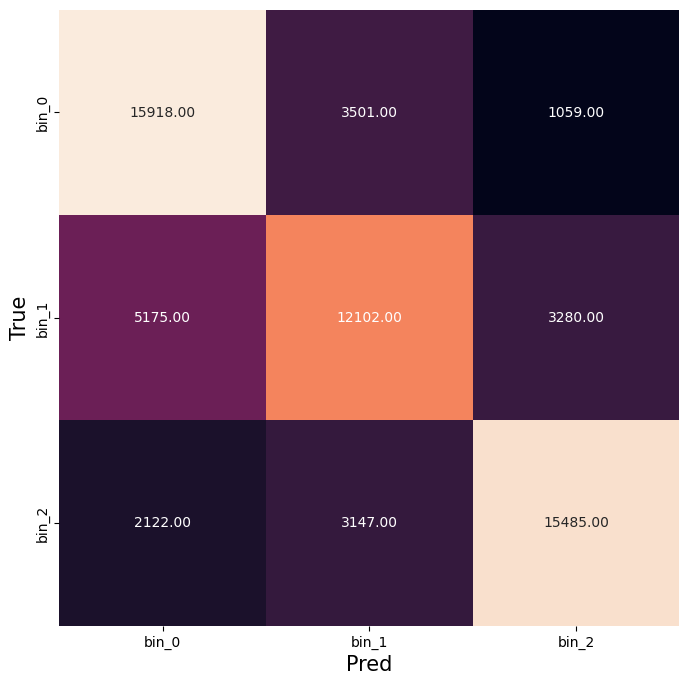

In [20]:
cm = confusion_matrix(target_val, model.predict(features_val))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='.2f', 
    cbar=False, 
    xticklabels=unique_labels(le.inverse_transform(target_val)), 
    yticklabels=unique_labels(le.inverse_transform(target_val))
)

ax.set_xlabel('Pred', fontsize=15)
ax.set_ylabel('True', fontsize=15)
plt.show()

### Важность признаков

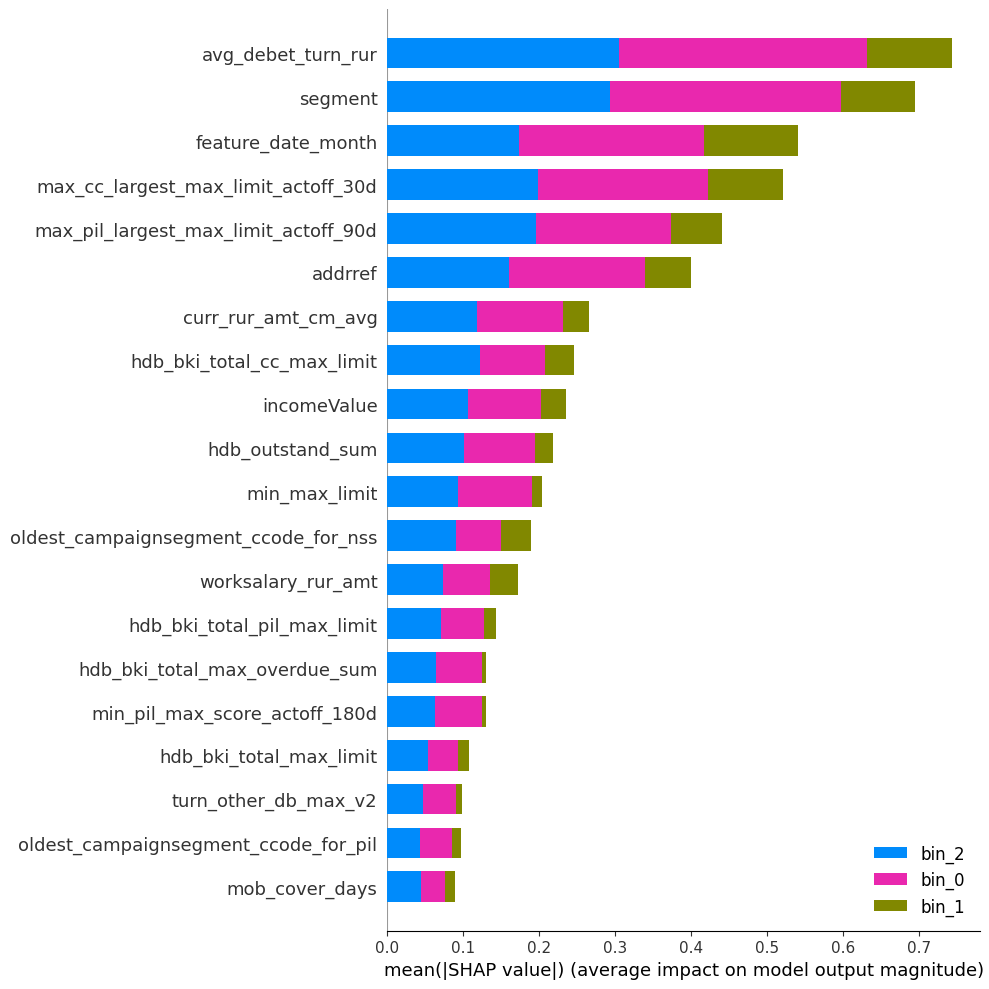

In [21]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val)
)

shap.summary_plot(
    shap_values, 
    features_val, 
    class_names = unique_labels(le.inverse_transform(target_val)),
    plot_size = (10,  10)
)

In [22]:
shap_importance = (
    pd.DataFrame(
        {
            "feature":  features_train.columns, 
            "importance": sum([np.mean(np.abs(shap_class), axis=0) for shap_class in shap_values])
        }
    ).sort_values("importance", ascending=False, ignore_index=True)
)
shap_importance.head()

,feature,importance
0,avg_debet_turn_rur,0.743651
1,segment,0.695019
2,feature_date_month,0.541034
3,max_cc_largest_max_limit_actoff_30d,0.521619
4,max_pil_largest_max_limit_actoff_90d,0.441250


## Отбор фич (факторный анализ)

In [23]:
# по пропущенным значениям

def feats_filter_nan(df: pd.DataFrame,
                     num_feat: list,
                     cat_feat: list,
                     nan_threshold: float):

    """Функция отбора фичей по доле NaN-значений.
    Фичи, которые имеют долю NaN-значений не ниже заданного nan_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    num_feat : list
        список числовых фичей
    cat_feat : list
        список категориальных фичей (в нашем случае для них NaN-значением является 'miss_value')
    nan_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    # для числовых фичей
    nan_stats_num = (
        df[num_feat]
        .isna().mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )
    # для категориальных
    nan_stats_cat = (
        (df[cat_feat] == 'miss_value')
        .mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )

    nan_stats = pd.concat([nan_stats_num, nan_stats_cat])
    selected_features = list(nan_stats[nan_stats['nan_frac'] < nan_threshold]['col'])

    return selected_features


deleted_features = list(set(features) - set(feats_filter_nan(train_df, num_features, cat_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nan(train_df, num_features, cat_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
38,first_salary_income,0.029446
60,product_depozity_voc_features_full_voc_without...,0.008273
67,hdb_bki_other_active_auto_month_payments_sum,0.004557
68,brand,0.004530
74,part_last_position_ccode,0.003746
97,channel_mobilnoe_prilozhenie_am_voc_features_3...,0.000470
100,part_pre_last_position_ccode,0.000104
101,channel_chatbot_alfainvestitsii_voc_features_3...,0.000062
102,channel_glid_voc_features_12m_mark_in_1_3_flag,0.000038
105,product_debetovye_karty_voc_features_full_min_...,0.000000


146

Отброшены потенциально хорошие фичи.
Вернем их в список фичей

In [24]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:5]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

151

In [25]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    """Функция отбора фичей по доле самого частого значения.
    Фичи, которые имеют 1 уникальное значение (помимо NaN), либо для которых
      доля самого частого значения (включая NaN) не ниже unique_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    unique_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    selected_features = []

    for feat in features:
        if df[feat].nunique() >= 2 and df[feat].astype(str).value_counts(1).values[0] < unique_threshold:
            selected_features += [feat]

    return selected_features

deleted_features = list(set(selected_features) - set(feats_filter_nunique(train_df, selected_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nunique(train_df, selected_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
38,first_salary_income,0.029446
60,product_depozity_voc_features_full_voc_without...,0.008273
67,hdb_bki_other_active_auto_month_payments_sum,0.004557
68,brand,0.004530
74,part_last_position_ccode,0.003746
87,channel_bankomaty_voc_features_full_voc_not_nu...,0.001825
170,channel_otdelenija_voc_features_full_voc_not_n...,0.000000
232,loan_on_realty_clicks_90,0.000000


143

In [26]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:5]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

148

In [27]:
# отсечение по рандомной фиче

def feats_filter_random_feat(df: pd.DataFrame,
                             features: list,
                             cat_features: list):

    """Функция отбора фичей при помощи отсечения менее важных фичей чем рандомная фича.
    Фичи, которые имеют в простой модели важность ниже рандомной фичи, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    cat_features : list
        список категориальных фичей

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """
    df_copy = df.copy()
    df_copy['random'] = np.random.uniform(0, 1, df_copy.shape[0])

    pool_train = Pool(
        df_copy[features + ['random']],
        df_copy['target_bins'],
        cat_features = cat_features
    )

    simple_model = CatBoostClassifier(
        iterations=400,
        learning_rate=0.05,
        loss_function='MultiClass',
        random_seed = 42
    )

    simple_model.fit(
        pool_train,
        verbose=100,
        early_stopping_rounds = 15,
    )

    shap_values = (
        shap
        .TreeExplainer(simple_model)
        .shap_values(df_copy[features + ['random']])
    )

    model_importance = (
        pd.DataFrame(
            {
                "feature":  features + ['random'], 
                "importance": sum([np.mean(np.abs(shap_class), axis=0) for shap_class in shap_values])
            }
        ).sort_values("importance", ascending=False, ignore_index=True)
    )

    selected_features = list(
        model_importance[
            model_importance['importance'] 
            > model_importance.loc[model_importance['feature'] == 'random', 'importance'].values[0]
        ]['feature']
    )

    return selected_features


_selected_features = feats_filter_random_feat(train_df, selected_features, selected_features_cat)
deleted_features = list(set(selected_features) - set(_selected_features))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = _selected_features
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

0:	learn: 1.0752634	total: 408ms	remaining: 2m 42s
100:	learn: 0.7229438	total: 43.2s	remaining: 2m 7s
200:	learn: 0.6907266	total: 1m 23s	remaining: 1m 23s
300:	learn: 0.6733519	total: 2m 5s	remaining: 41.3s
399:	learn: 0.6630836	total: 2m 46s	remaining: 0us


,feature,importance
70,product_kreditnye_karty_voc_features_3m_mark_e...,0.003942
73,product_other_depos_ratio_hy,0.003750
75,channel_telemarketing_voc_features_3m_voc_not_...,0.003243
80,transaction_category_other_retail_purchase_per...,0.002283
82,flg_nss_presence_in_previous_30_days_with_150_...,0.002093
85,product_debetovye_karty_voc_features_full_mark...,0.001982
86,count_device_samsung_0_60_days,0.001871
88,channel_chat_s_operatorom_voc_features_3m_mark...,0.001722
89,product_brokerskoe_obsluzhivanie_voc_features_...,0.001454
91,product_debetovye_karty_voc_features_36m_voc_n...,0.001278


89

## Обучение модели на фичах после факторного анализа

In [28]:
model = fit_catboost(
    features_train[selected_features],
    features_val[selected_features], 
    target_train,
    target_val, 
    selected_features_cat,
    400, 
    0.05
)

print(
    classification_report(
        target_val, 
        model.predict(features_val[selected_features]),
        target_names = unique_labels(le.inverse_transform(target_val))
    ) 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0755564	test: 1.0753217	best: 1.0753217 (0)	total: 288ms	remaining: 1m 54s
100:	learn: 0.7240360	test: 0.7265765	best: 0.7265765 (100)	total: 31.6s	remaining: 1m 33s
200:	learn: 0.6904298	test: 0.6955640	best: 0.6955640 (200)	total: 1m 2s	remaining: 1m 1s
300:	learn: 0.6728789	test: 0.6806748	best: 0.6806748 (300)	total: 1m 32s	remaining: 30.5s
399:	learn: 0.6615903	test: 0.6723904	best: 0.6723904 (399)	total: 2m 2s	remaining: 0us

bestTest = 0.6723903602
bestIteration = 399

              precision    recall  f1-score   support

       bin_0       0.69      0.78      0.73     20478
       bin_1       0.64      0.59      0.61     20557
       bin_2       0.78      0.75      0.76     20754

    accuracy                           0.70     61789
   macro avg       0.70      0.70      0.70     61789
weighted avg       0.70      0.70      0.70     61789



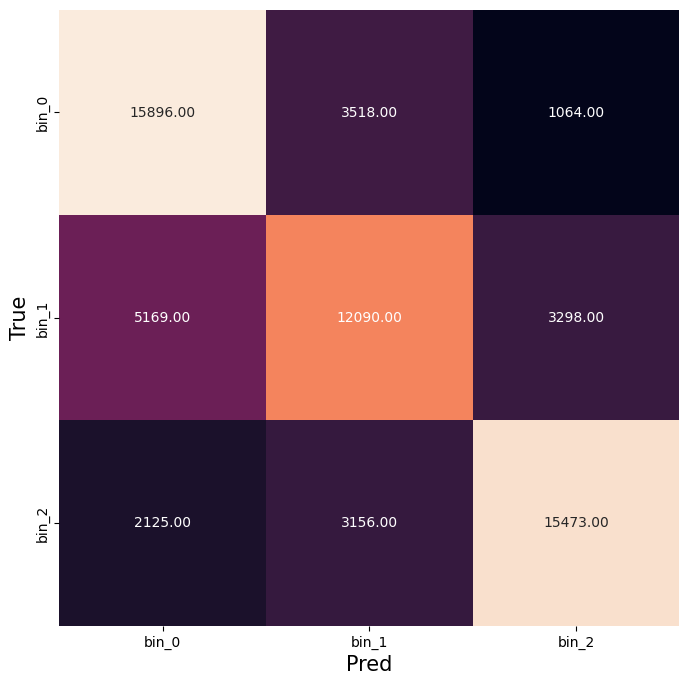

In [29]:
cm = confusion_matrix(target_val, model.predict(features_val[selected_features]))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='.2f', 
    cbar=False, 
    xticklabels=unique_labels(le.inverse_transform(target_val)), 
    yticklabels=unique_labels(le.inverse_transform(target_val))
)

ax.set_xlabel('Pred', fontsize=15)
ax.set_ylabel('True', fontsize=15)
plt.show()

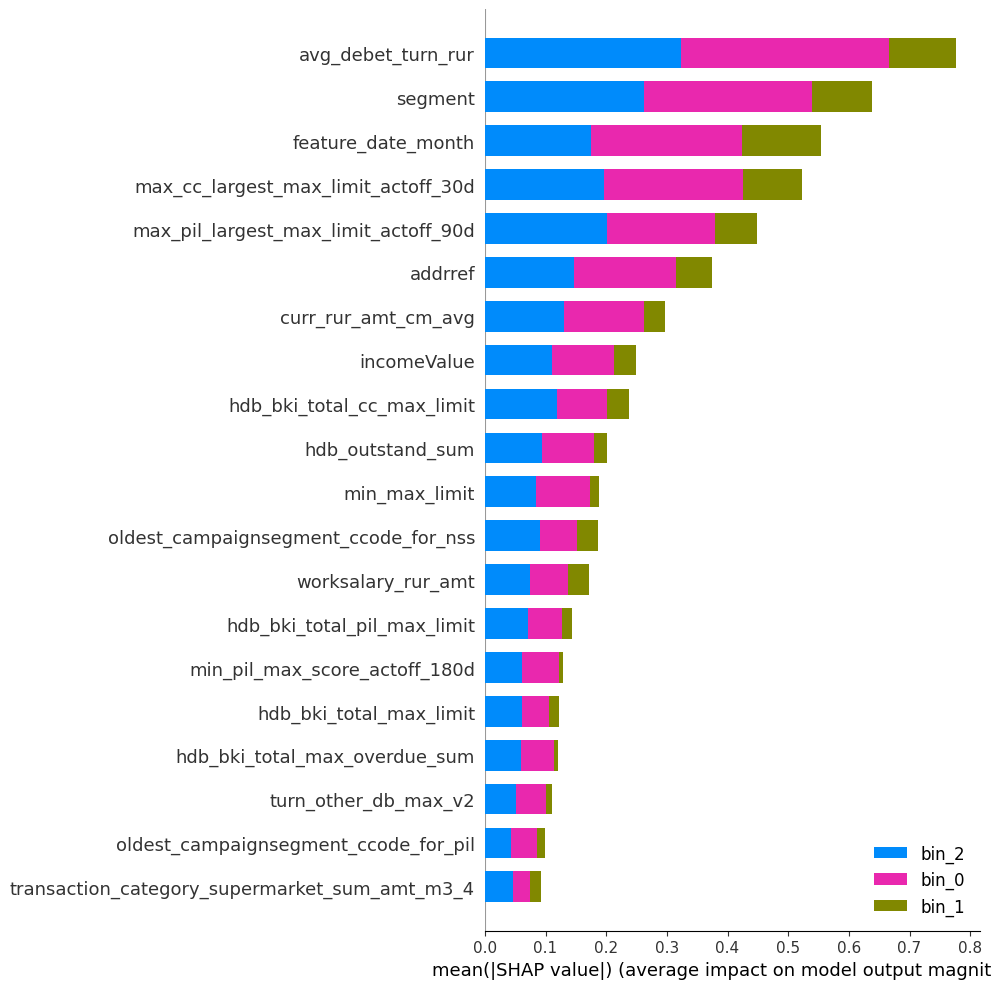

In [30]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val[selected_features])
)

shap.summary_plot(
    shap_values, 
    features_val[selected_features], 
    class_names = unique_labels(le.inverse_transform(target_val)),
    plot_size = (10,  10)
)

# Обучение модели 2 класса  
в файле 06_ensemble_3model_clf выдвинута гипотеза о том, что разбиение выборки на клиентов с нормальными и экстримальными доходами может улучшить итоговый результат

In [68]:
train_df = train_df.drop('target_bins', axis=1)

In [134]:
train_df = train_df.drop('target_bins', axis=1)

q = train_df['target'].quantile(0.9)
train_df['target_bins'] = train_df['target'].apply(lambda x:  0 if x < q else 1)

features_train, features_val, target_train, target_val = train_test_split(
    train_df[features],
    train_df['target_bins'], 
    test_size=0.3,
    random_state=42
)

train_df['target_bins'].value_counts()


target_bins
0    185335
1     20627
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='Density'>

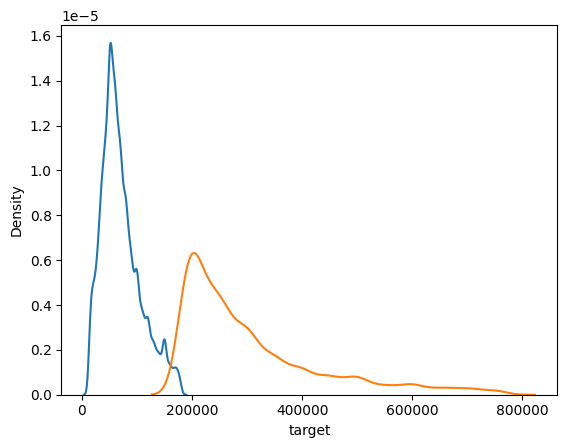

In [135]:
sns.kdeplot(train_df.loc[train_df['target_bins'] == 0, 'target'])
sns.kdeplot(train_df.loc[train_df['target_bins'] == 1, 'target'])

## Обучение модели на всех фичах

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6298779	test: 0.6300269	best: 0.6300269 (0)	total: 197ms	remaining: 1m 18s
100:	learn: 0.1744741	test: 0.1777427	best: 0.1777427 (100)	total: 18.7s	remaining: 55.5s
200:	learn: 0.1644379	test: 0.1696595	best: 0.1696595 (200)	total: 38.1s	remaining: 37.7s
300:	learn: 0.1584355	test: 0.1660144	best: 0.1660144 (300)	total: 57.7s	remaining: 19s
399:	learn: 0.1538906	test: 0.1637762	best: 0.1637762 (399)	total: 1m 16s	remaining: 0us

bestTest = 0.1637761602
bestIteration = 399

f1:  0.6330761364692757


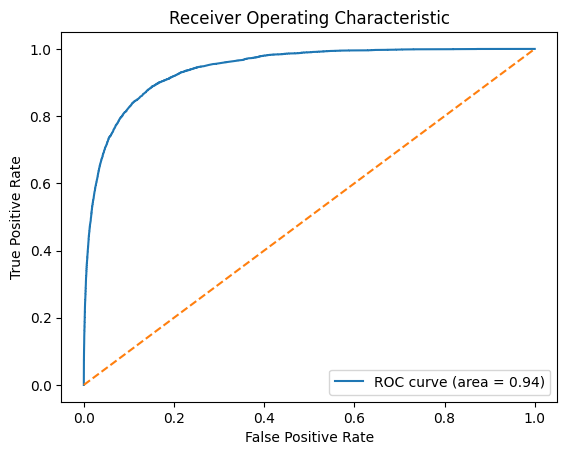

In [136]:
model = fit_catboost(
    features_train, 
    features_val, 
    target_train, 
    target_val, 
    cat_features, 
    400, 
    0.05,
    'Logloss'
)

print('f1: ', f1_score(target_val, model.predict(features_val)))

fpr, tpr, thresholds = roc_curve(target_val, model.predict_proba(features_val)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,  1], [0,  1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

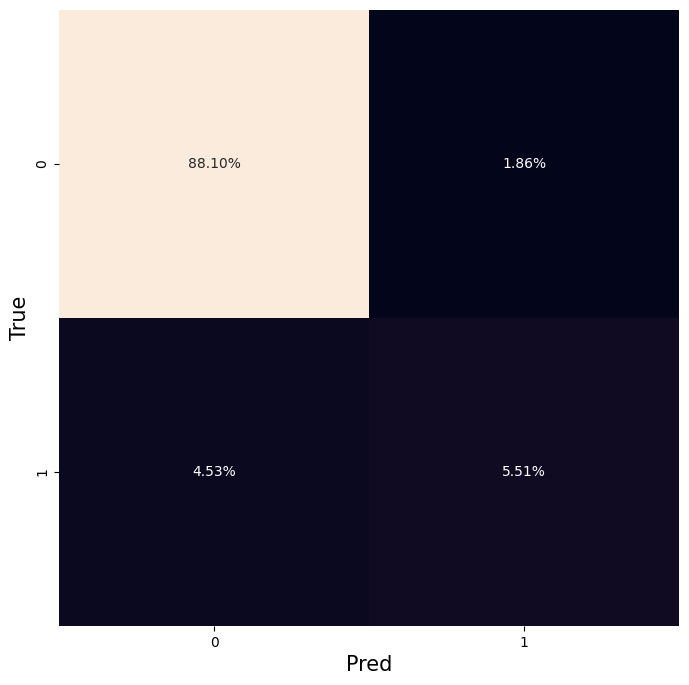

In [137]:
cm = confusion_matrix(target_val, model.predict(features_val))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm/np.sum(cm), 
    annot=True, 
    fmt='.2%', 
    cbar=False, 
    xticklabels=unique_labels(le.inverse_transform(target_val)), 
    yticklabels=unique_labels(le.inverse_transform(target_val))
)

ax.set_xlabel('Pred', fontsize=15)
ax.set_ylabel('True', fontsize=15)
plt.show()

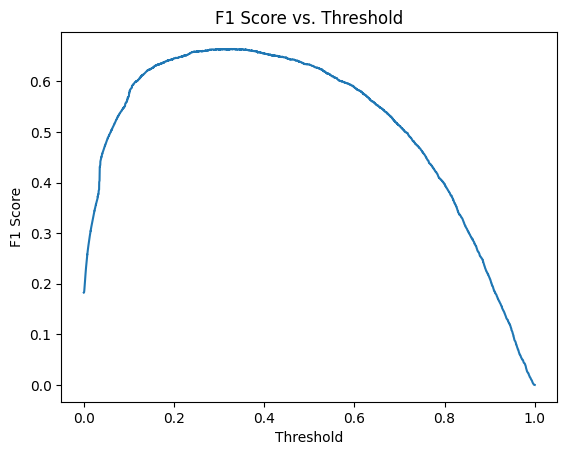

Лучший трешхолд:0.3327693816617344


In [155]:
precision, recall, thresholds = precision_recall_curve(target_val, model.predict_proba(features_val)[:,1])
thresholds = np.append(thresholds, 1)

beta = 1
f1_scores =  (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()

best_trash = thresholds[np.argmax(f1_scores)]
print(f'Лучший трешхолд:{best_trash}')

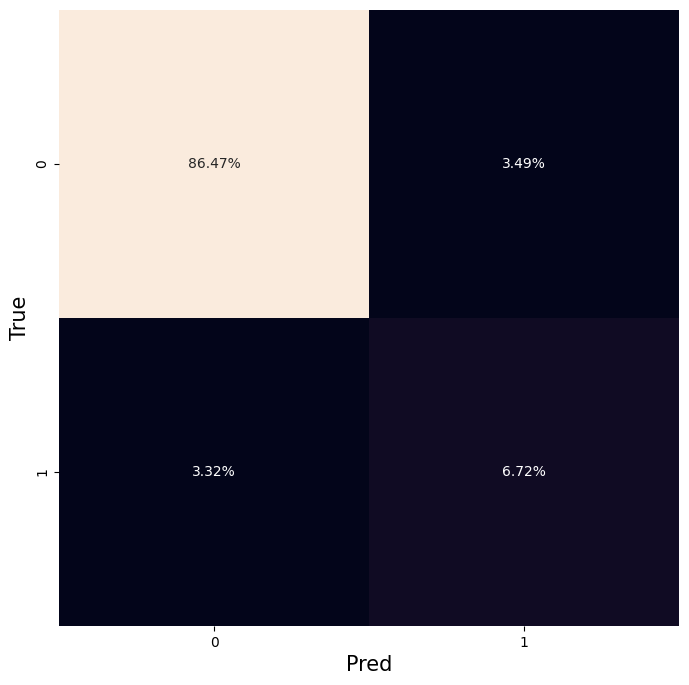

In [156]:
model.set_probability_threshold(best_trash)

cm = confusion_matrix(target_val, model.predict(features_val))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm/np.sum(cm), 
    annot=True, 
    fmt='.2%', 
    cbar=False, 
    xticklabels=unique_labels(le.inverse_transform(target_val)), 
    yticklabels=unique_labels(le.inverse_transform(target_val))
)

ax.set_xlabel('Pred', fontsize=15)
ax.set_ylabel('True', fontsize=15)
plt.show()

### Важность признаков

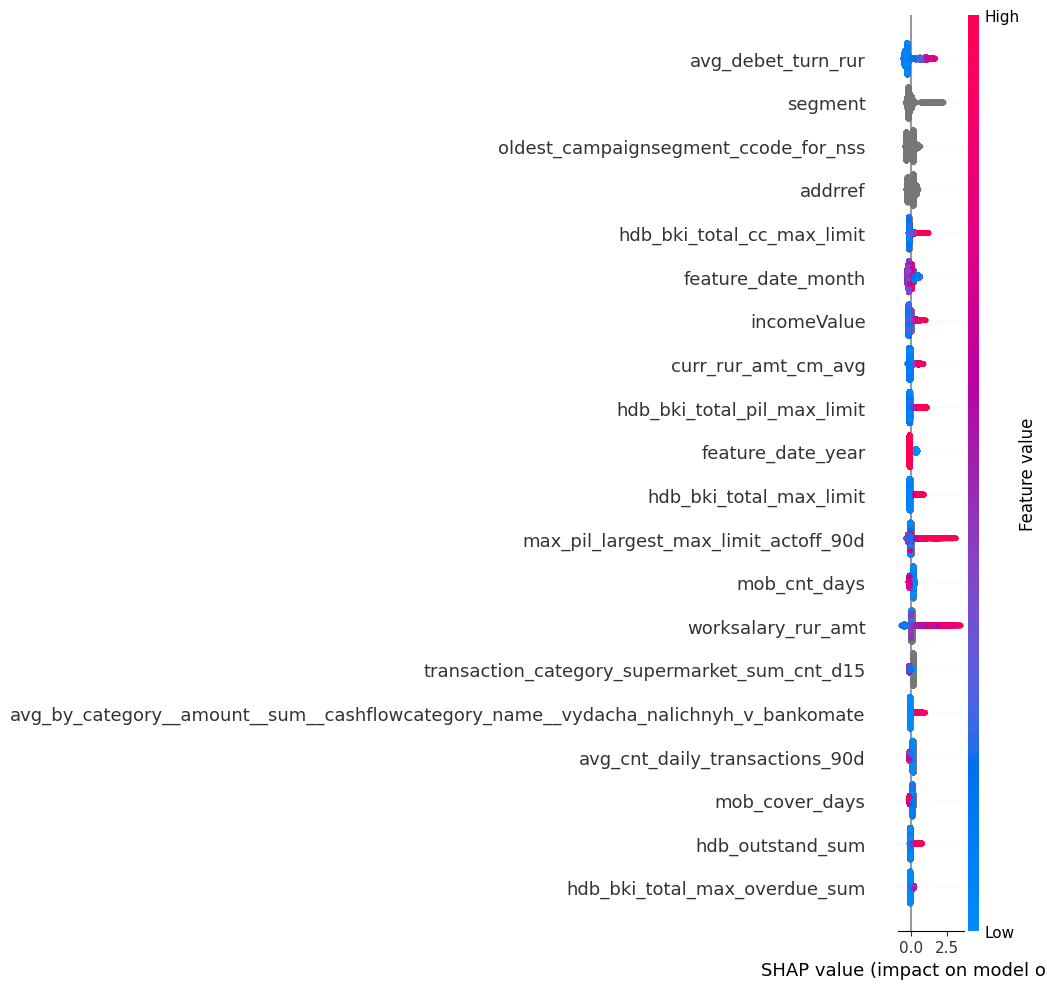

In [140]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val)
)

shap.summary_plot(
    shap_values, 
    features_val, 
    class_names = unique_labels(le.inverse_transform(target_val)),
    plot_size = (10,  10)
)

In [141]:
shap_importance = (
    pd.DataFrame(
        {"feature":  features_train.columns, "importance": np.mean(np.abs(shap_values), axis=0)}
    ).sort_values("importance", ascending=False, ignore_index=True)
)
shap_importance.head()

,feature,importance
0,avg_debet_turn_rur,0.462333
1,segment,0.293698
2,oldest_campaignsegment_ccode_for_nss,0.232386
3,addrref,0.232223
4,hdb_bki_total_cc_max_limit,0.173097


## Отбор фич (факторный анализ)

In [142]:
# по пропущенным значениям

def feats_filter_nan(df: pd.DataFrame,
                     num_feat: list,
                     cat_feat: list,
                     nan_threshold: float):

    """Функция отбора фичей по доле NaN-значений.
    Фичи, которые имеют долю NaN-значений не ниже заданного nan_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    num_feat : list
        список числовых фичей
    cat_feat : list
        список категориальных фичей (в нашем случае для них NaN-значением является 'miss_value')
    nan_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    # для числовых фичей
    nan_stats_num = (
        df[num_feat]
        .isna().mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )
    # для категориальных
    nan_stats_cat = (
        (df[cat_feat] == 'miss_value')
        .mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )

    nan_stats = pd.concat([nan_stats_num, nan_stats_cat])
    selected_features = list(nan_stats[nan_stats['nan_frac'] < nan_threshold]['col'])

    return selected_features


deleted_features = list(set(features) - set(feats_filter_nan(train_df, num_features, cat_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nan(train_df, num_features, cat_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
28,first_salary_income,0.047103
62,hdb_bki_other_active_auto_month_payments_sum,0.005775
70,part_last_position_ccode,0.004491
85,part_pre_last_position_ccode,0.001672
86,model,0.001531
88,brand,0.001424
89,product_depozity_voc_features_full_voc_without...,0.001364
96,avg_by_category__amount__sum__cashflowcategory...,0.000983
105,min_cc_max_pilot_score_actoff_180d,0.000492
108,product_ipoteka_voc_features_full_mark_eq_3_flag,0.000177


146

Отброшены потенцильно хорошие фичи.
Вернем их в список фичей

In [143]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:6]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

152

In [144]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    """Функция отбора фичей по доле самого частого значения.
    Фичи, которые имеют 1 уникальное значение (помимо NaN), либо для которых
      доля самого частого значения (включая NaN) не ниже unique_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    unique_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    selected_features = []

    for feat in features:
        if df[feat].nunique() >= 2 and df[feat].astype(str).value_counts(1).values[0] < unique_threshold:
            selected_features += [feat]

    return selected_features

deleted_features = list(set(selected_features) - set(feats_filter_nunique(train_df, selected_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nunique(train_df, selected_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
28,first_salary_income,0.047103
62,hdb_bki_other_active_auto_month_payments_sum,0.005775
70,part_last_position_ccode,0.004491
85,part_pre_last_position_ccode,0.001672
86,model,0.001531
88,brand,0.001424
182,channel_otdelenija_voc_features_full_voc_not_n...,0.000000
226,channel_bankomaty_voc_features_full_voc_not_nu...,0.000000
228,loan_on_realty_clicks_90,0.000000


143

In [145]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:6]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

149

In [146]:
# отсечение по рандомной фиче

def feats_filter_random_feat(df: pd.DataFrame,
                             features: list,
                             cat_features: list):

    """Функция отбора фичей при помощи отсечения менее важных фичей чем рандомная фича.
    Фичи, которые имеют в простой модели важность ниже рандомной фичи, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    cat_features : list
        список категориальных фичей

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """
    df_copy = df.copy()
    df_copy['random'] = np.random.uniform(0, 1, df_copy.shape[0])

    pool_train = Pool(
        df_copy[features + ['random']],
        df_copy['target_bins'],
        cat_features = cat_features
    )

    simple_model = CatBoostClassifier(
        iterations=400,
        learning_rate=0.05,
        loss_function='Logloss',
        random_seed = 42
    )

    simple_model.fit(
        pool_train,
        verbose=100,
        early_stopping_rounds = 15,
    )

    shap_values = (
        shap
        .TreeExplainer(simple_model)
        .shap_values(df_copy[features + ['random']])
    )

    model_importance = (
        pd.DataFrame(
            {"feature":  features + ['random'], "importance": np.mean(np.abs(shap_values), axis=0)}
        ).sort_values("importance", ascending=False, ignore_index=True)
    )

    selected_features = list(
        model_importance[
            model_importance['importance'] 
            > model_importance.loc[model_importance['feature'] == 'random', 'importance'].values[0]
        ]['feature']
    )

    return selected_features


_selected_features = feats_filter_random_feat(train_df, selected_features, selected_features_cat)
deleted_features = list(set(selected_features) - set(_selected_features))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = _selected_features
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

0:	learn: 0.6284246	total: 208ms	remaining: 1m 23s
100:	learn: 0.1744682	total: 21.8s	remaining: 1m 4s
200:	learn: 0.1650999	total: 45s	remaining: 44.6s
300:	learn: 0.1595030	total: 1m 6s	remaining: 21.7s
399:	learn: 0.1553907	total: 1m 27s	remaining: 0us


,feature,importance
61,channel_chat_s_operatorom_voc_features_full_vo...,0.006289
78,card_dda_rur_amt_cm_avg_div_v2,0.002756
84,channel_chat_s_operatorom_voc_features_12m_mar...,0.001781
91,channel_chatbot_voc_features_12m_mark_in_1_3_flag,0.001334
95,transaction_category_hotels_sum_amt_m2,0.001018
97,product_kreditnye_karty_voc_features_full_mark...,0.000966
102,channel_vyezdnoj_kanal_voc_features_12m_voc_wi...,0.000647
106,channel_telemarketing_voc_features_36m_mark_in...,0.000280
120,product_brokerskoe_obsluzhivanie_voc_features_...,0.000015
129,product_kreditnye_karty_voc_features_36m_voc_w...,0.000000


114

## Обучение модели на фичах после факторного анализа

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6278260	test: 0.6280390	best: 0.6280390 (0)	total: 202ms	remaining: 1m 20s
100:	learn: 0.1740104	test: 0.1771484	best: 0.1771484 (100)	total: 18.5s	remaining: 54.7s
200:	learn: 0.1642026	test: 0.1692267	best: 0.1692267 (200)	total: 36.8s	remaining: 36.4s
300:	learn: 0.1581433	test: 0.1655409	best: 0.1655409 (300)	total: 55.1s	remaining: 18.1s
399:	learn: 0.1536807	test: 0.1634893	best: 0.1634893 (399)	total: 1m 13s	remaining: 0us

bestTest = 0.1634893361
bestIteration = 399

f1:  0.6327137546468402


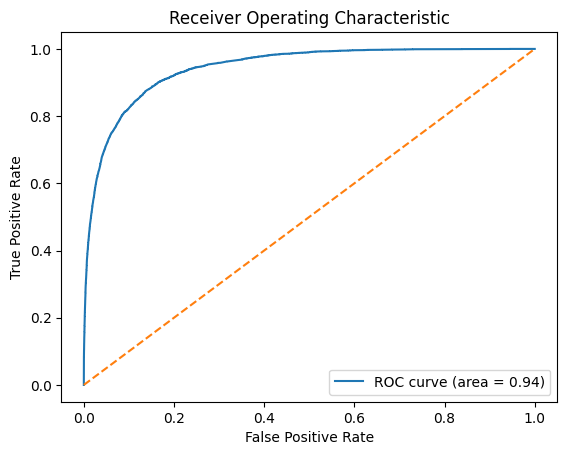

In [158]:
model = fit_catboost(
    features_train[selected_features], 
    features_val[selected_features], 
    target_train, 
    target_val, 
    cat_features, 
    400, 
    0.05,
    'Logloss'
)

print('f1: ', f1_score(target_val, model.predict(features_val[selected_features])))

fpr, tpr, thresholds = roc_curve(target_val, model.predict_proba(features_val[selected_features])[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,  1], [0,  1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

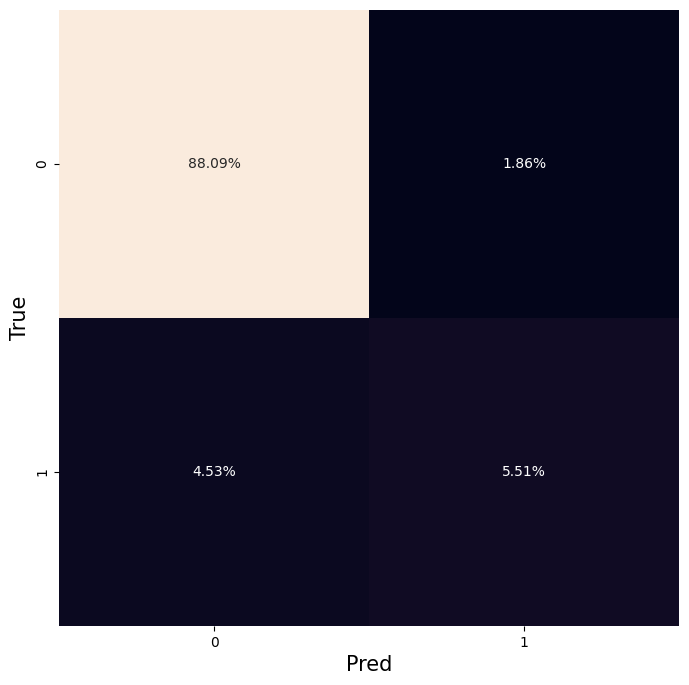

In [160]:
cm = confusion_matrix(target_val, model.predict(features_val[selected_features]))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm/np.sum(cm), 
    annot=True, 
    fmt='.2%', 
    cbar=False, 
    xticklabels=unique_labels(le.inverse_transform(target_val)), 
    yticklabels=unique_labels(le.inverse_transform(target_val))
)

ax.set_xlabel('Pred', fontsize=15)
ax.set_ylabel('True', fontsize=15)
plt.show()

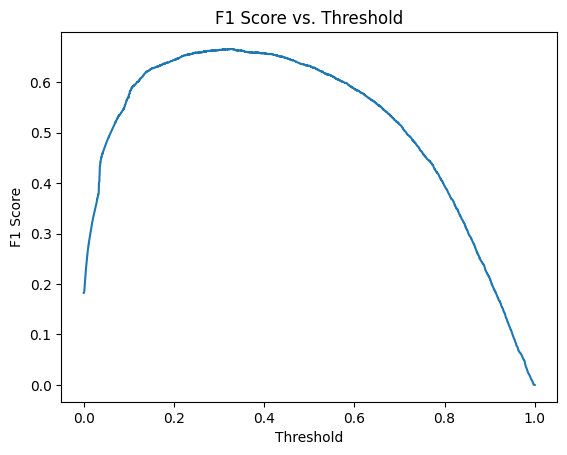

Лучший трешхолд:0.3264649336631194


In [161]:
precision, recall, thresholds = precision_recall_curve(target_val, model.predict_proba(features_val[selected_features])[:,1])
thresholds = np.append(thresholds, 1)

beta = 1
f1_scores =  (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()

best_trash = thresholds[np.argmax(f1_scores)]
print(f'Лучший трешхолд:{best_trash}')

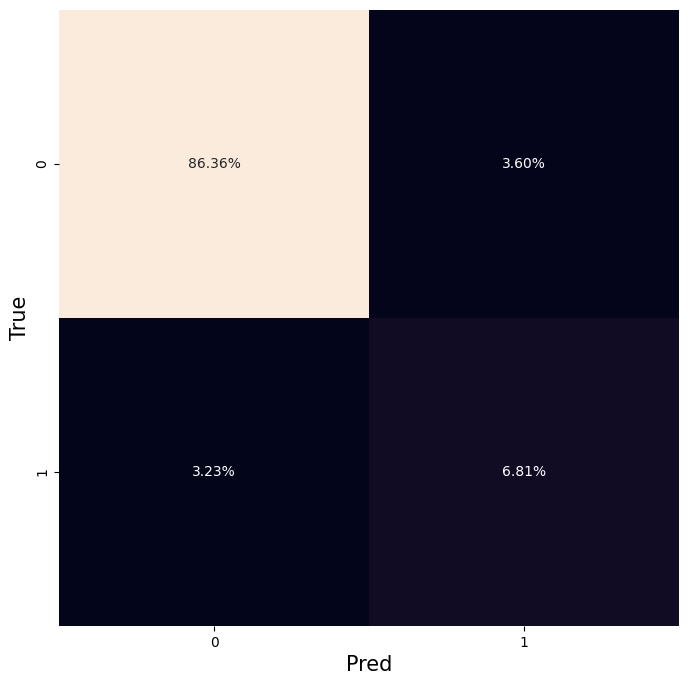

In [162]:
model.set_probability_threshold(best_trash)

cm = confusion_matrix(target_val, model.predict(features_val[selected_features]))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(
    cm/np.sum(cm), 
    annot=True, 
    fmt='.2%', 
    cbar=False, 
    xticklabels=unique_labels(le.inverse_transform(target_val)), 
    yticklabels=unique_labels(le.inverse_transform(target_val))
)

ax.set_xlabel('Pred', fontsize=15)
ax.set_ylabel('True', fontsize=15)
plt.show()

### Важность признаков

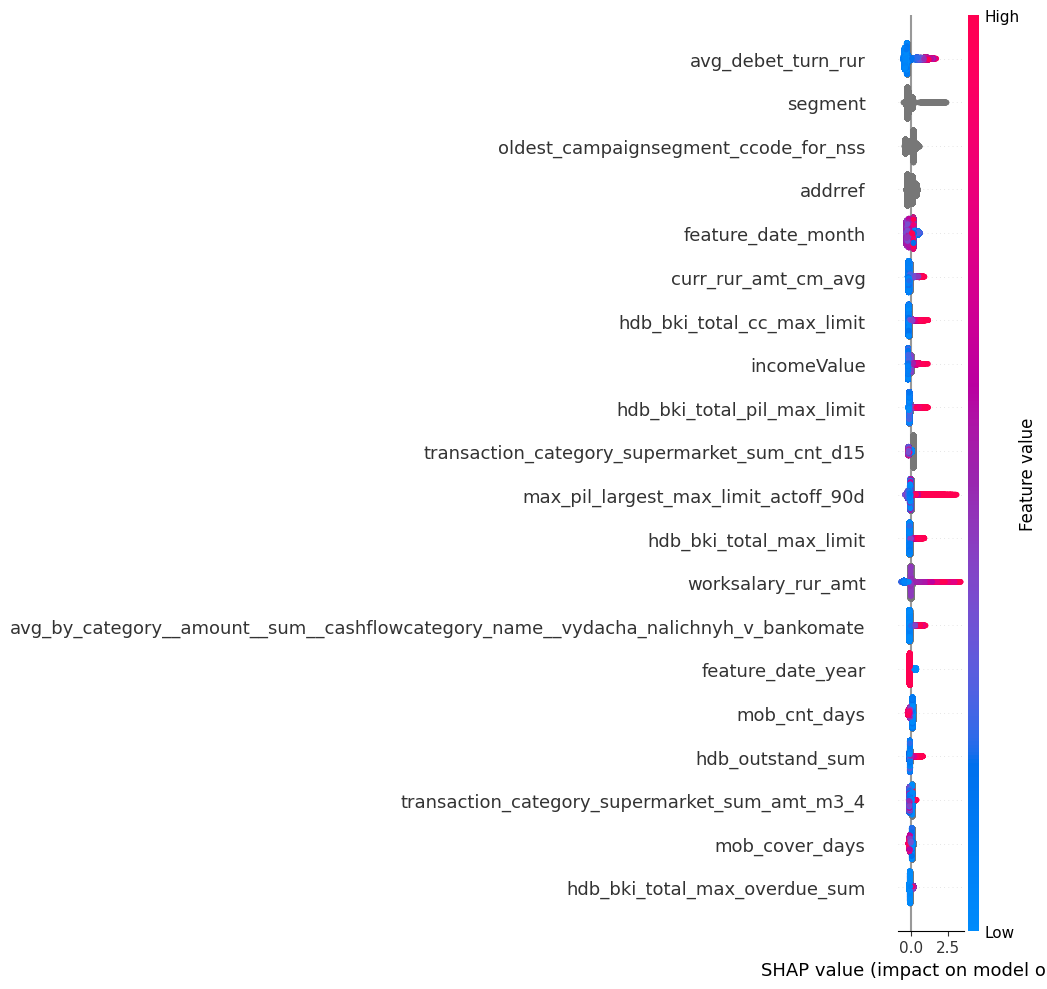

In [165]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val[selected_features])
)

shap.summary_plot(
    shap_values, 
    features_val[selected_features], 
    class_names = unique_labels(target_val),
    plot_size = (10,  10)
)

# Инференс

In [30]:
pool_train = Pool(
    train_df[selected_features],
    train_df['target_bins'],
    cat_features = selected_features_cat
)

model = CatBoostClassifier(
    iterations = 400,
    learning_rate = 0.05,
    random_seed = 42
)

model.fit(
    pool_train,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0590334	total: 420ms	remaining: 2m 47s
100:	learn: 0.5716936	total: 40.7s	remaining: 2m
200:	learn: 0.5393855	total: 1m 18s	remaining: 1m 17s
300:	learn: 0.5236663	total: 1m 57s	remaining: 38.5s
399:	learn: 0.5137151	total: 2m 36s	remaining: 0us


# Сохранение модели

In [31]:
# model.set_probability_threshold(best_trash)
model.save_model('models/3cl_6_9_model_clf')

In [32]:
with open('models/3cl_6_9_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)